In [1]:
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
import torch.optim as optim
from src.train import Trainer # Import trainer
from src.utils import display_stats # Import methode for display training stats
from src.preprocess import load_data # Import the data loading function
from src.model import TeacherModel # Import the model class

In [2]:
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
print(f'Device: {device}')

# Training parameters
epochs = 30
batch_size = 32
learning_rate = 1e-3
validation_split=0.1

# Load the MNIST dataset
train_loader, valid_loader, test_dataloader = load_data(batch_size=batch_size, validation_split=validation_split)

# Initialize the model and training components
teacher_m = TeacherModel()
criterion_teacher = nn.CrossEntropyLoss()
sgd_t = optim.SGD(teacher_m.parameters(), lr=learning_rate, momentum=0.0)
trainer_t = Trainer(teacher_m, device)

Device: mps


## TRAINING TEACHER MODEL

In [3]:
# Lists to store the training and validation statistics
train_losses = []
valid_losses = []
train_acc = []
valid_acc = []

# Training loop
for _ in tqdm(range(epochs), desc="Epochs: "):
    # Set model to training mode and reset statistics at the start of each epoch
    teacher_m.train()
    trainer_t.init_params()
    for data_train in train_loader:
        # Perform training steps
        trainer_t.train_step(data_train, criterion_teacher, sgd_t)
    # Store training stats for this epoch
    train_losses.append(trainer_t.train_loss / len(train_loader))
    train_acc.append(trainer_t.train_acc / len(train_loader.dataset))
    with torch.no_grad():
        for data_val in valid_loader:
            # Perform validation steps
            trainer_t.val_step(data_val, criterion_teacher)
        # Store validation stats for this epoch
        valid_losses.append(trainer_t.val_loss / len(valid_loader))
        valid_acc.append(trainer_t.val_acc / len(valid_loader.dataset))
print("Training completed.")

Epochs: 100%|██████████| 30/30 [08:50<00:00, 17.70s/it]

Training completed.


In [4]:
# Save training and validation statistics to a file
np.savez("stats/teacher_model_stats.npz", train_losses=np.array(train_losses), train_acc=np.array(train_acc), valid_losses=np.array(valid_losses), valid_acc=np.array(valid_acc), allow_pickle=True)
# Save the trained model parameters
torch.save(teacher_m.state_dict(), "models/teacher_model.pth")
print("Model saved to models/teacher_model.pth")

Model saved to models/teacher_model.pth


In [5]:
# Define the path to your training statistics
TRAINING_STATS = "stats/teacher_model_stats.npz"

In [6]:
# Load model training statistics (accuracy and loss)
training_stats  = np.load(TRAINING_STATS)

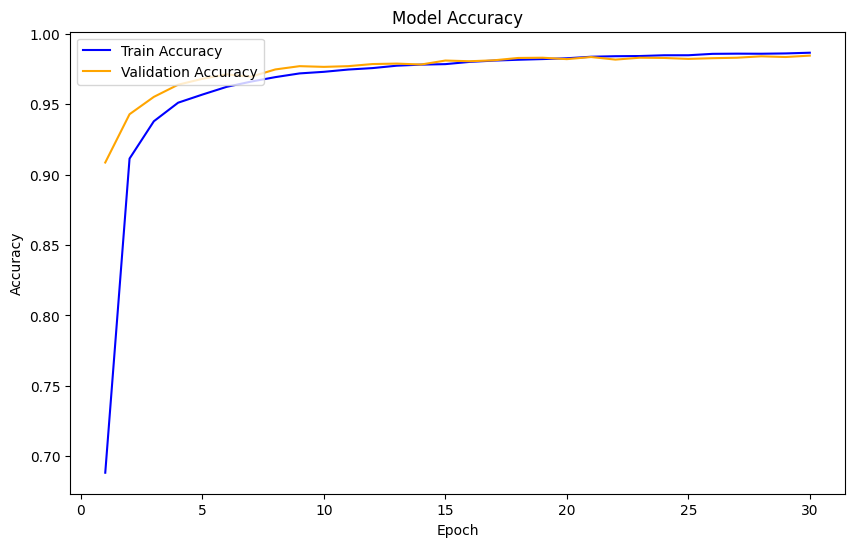

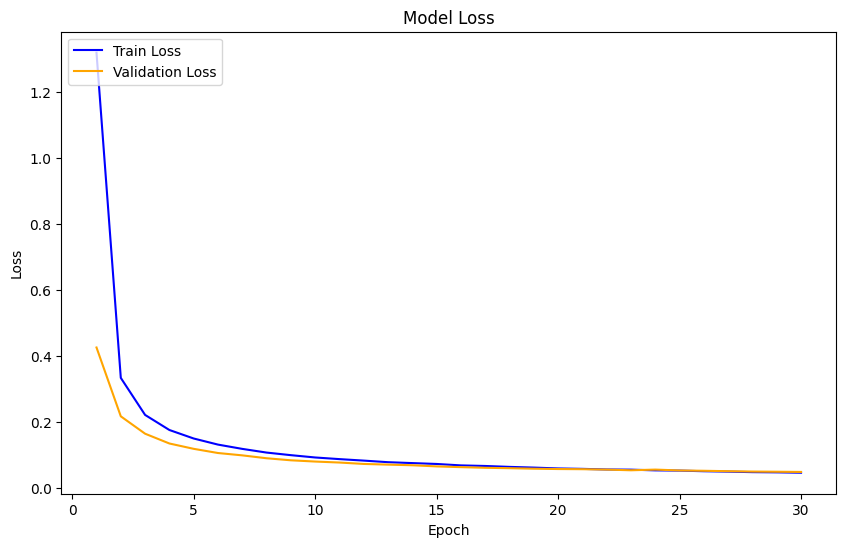

In [7]:
# Display the training statistics
display_stats(training_stats)

## EVALUATE TEACHER MODEL

In [8]:
# Evaluate model performance on the entire test dataset
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in test_dataloader:
        data, target = data.to(device), target.to(device)
        output = teacher_m(data)
        test_loss += criterion_teacher(output, target).item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()   
# Compute the average loss across all test samples
test_loss /= len(test_dataloader)
# Print evaluation results
print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({100. * correct / len(test_dataloader.dataset):.0f}%)\n')


Test set: Average loss: 0.0372, Accuracy: 9880/10000 (99%)

